# Image classification: dogs & cats

In [14]:
# Handle imports up-front
import os
import sys
import glob
import random

# Silence logging messages from TensorFlow, except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# PyPI imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Import image from keras correctly based on the TensorFlow version
tf_version = float('.'.join(tf.__version__.split('.')[0:2]))
print(f'Tensorflow version {tf_version}')

if tf_version > 2.8:
    import keras.utils as image

else:
    from keras.preprocessing import image

# Figure out if we are running on Kaggle or not, if so
# add the location of utils.py to path so we can import
path_list = os.getcwd().split(os.sep)

if path_list[1] == 'kaggle':
    sys.path.append('/kaggle/usr/lib/image_classification_functions')

# Import custom helper functions from utils.py
from image_classification_functions import prep_data
from image_classification_functions import single_training_run
from image_classification_functions import plot_single_training_run
from image_classification_functions import hyperparameter_optimization_run
from image_classification_functions import plot_hyperparameter_optimization_run

# Silence logging messages from TensorFlow, except errors
tf.get_logger().setLevel('ERROR')


Tensorflow version 2.2


In [29]:
import os
import shutil

# Correct path to kaggle.json (one directory up from notebooks/)
source = os.path.join(os.getcwd(), "../kaggle.json")
destination = os.path.expanduser("~/.kaggle/kaggle.json")

# Create .kaggle directory if it doesn't exist
os.makedirs(os.path.dirname(destination), exist_ok=True)

# Copy instead of move (to avoid cross-device link error)
shutil.copy(source, destination)

# Set permissions
os.chmod(destination, 0o600)

print("✅ kaggle.json configured successfully.")




✅ kaggle.json configured successfully.


## 1. Data preparation

### 1.1. Load the data paths

In [30]:
# Decompress and organize the images
training_data_path, validation_data_path, testing_data_path = prep_data()

# Get lists of training and validation dog and cat images
training_dogs = glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats = glob.glob(f'{training_data_path}/cats/cat.*')
validation_dogs = glob.glob(f'{validation_data_path}/dogs/dog.*')
validation_cats = glob.glob(f'{validation_data_path}/cats/cat.*')


Not running in Kaggle notebook
Checking data prep
Missing images, final count: 0
Running data prep
Image archive should be at ../data/images/raw/dogs-vs-cats.zip
../data/images/raw/dogs-vs-cats.zip does not exist
Image extraction complete
Making training and testing datasets
Moving files to training, validation & testing, cat & dog subdirectories
Done


In [42]:
print("Training path:", training_data_path)
print("Validation path:", validation_data_path)
print("Testing path:", testing_data_path)

print("Number of training cat images:", len(training_cats))
print("Number of training dog images:", len(training_dogs))


Training path: ../data/images/training
Validation path: ../data/images/validation
Testing path: ../data/images/testing
Number of training cat images: 0
Number of training dog images: 0


### 1.2. Inspect

Number of cat images: 0
Number of dog images: 0


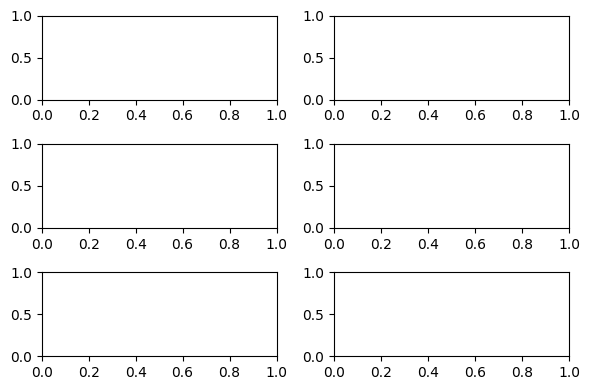

In [41]:
# Plot some of the cat and dog images
fig, axs = plt.subplots(3, 2, figsize=(6, 4))

print("Number of cat images:", len(training_cats))
print("Number of dog images:", len(training_dogs))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    print("Cat path:", cat)
    print("Dog path:", dog)

    for animal, ax in zip([cat, dog], row):
        animal = image.load_img(animal)
        animal = image.img_to_array(animal)
        animal /= 255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()


## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [4]:
# Load one of the images as an array and look at it's shape - what do you see, what are the dimensions? Are they what you expect?

# Load a sample image 
sample_image_path = training_dogs[0]

# Load the image
sample_image = image.load_img(sample_image_path)

# Convert to array
sample_array = image.img_to_array(sample_image)

# Print shape
print(f"Image shape: {sample_array.shape}") 

# Display the image
plt.imshow(sample_array.astype("uint8"))
plt.title("Sample Dog Image")
plt.axis("off")
plt.show()


IndexError: list index out of range

In [ ]:
# Plot a histogram of the three 2D arrays which comprise the image. What do you see?

### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

In [ ]:
# Loop over a few hundred images and extract their width and heigh, plot both as a histogram. What do you see, does this information matter to us, if so, how?

### 2.3. Image aspect ratios

In [ ]:
# Plot a histogram of the image aspect ratios (i.e. width/height) What do you see, does this information matter to us, if so, how?

## 3. Build the model

### 3.1. Prepare images for streaming

In [ ]:
def make_datasets(
        training_data_path: str,
        image_width: int,
        image_height: int, 
        batch_size: int=32,
        steps_per_epoch: int=50,
        epochs: int=10
) -> Tuple[tf.data.Dataset, tf.data.Dataset]:

    training_dataset, validation_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='both',
        seed=315,
        shuffle=True,
        image_size=(image_width, image_height),
        batch_size=batch_size
    )

    epoch_images=batch_size*steps_per_epoch
    total_images=epoch_images*epochs

    training_dataset=training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()
    validation_dataset=training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()

    return training_dataset, validation_dataset


training_dataset, validation_dataset=make_datasets(
    training_data_path,
    image_width=64,
    image_height=48,
    batch_size=64,
    steps_per_epoch=50,
    epochs=100
)

### 3.1. Model definition

In [ ]:
def compile_model(image_width, image_height, learning_rate):

    initializer=tf.keras.initializers.GlorotUniform(seed=315)

    model=Sequential([
        layers.Input((image_width, image_height, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

    return model


model=compile_model(
    image_width=64,
    image_height=48, 
    learning_rate=0.1
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,057 (1.59 MB)

 Trainable params: 417,057 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2. Model training

In [ ]:
%%time

training_results=model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=100,
  steps_per_epoch=50,
  validation_steps=50,
  verbose=0
)

print()


CPU times: user 24min 40s, sys: 1min 10s, total: 25min 51s
Wall time: 16min 23s


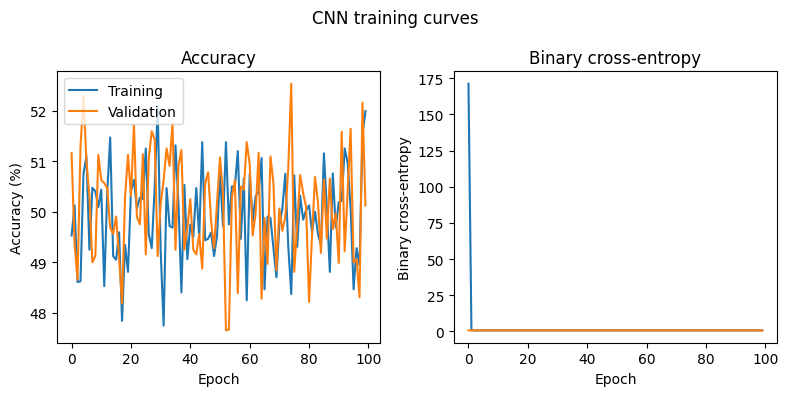

In [ ]:
# Take a look the information 'training_results' contains. Plot the training 
# and validation accuracy (and binary cross-entropy if you like) over the
# training epochs. Is the model learning? If not, what do you think
# is wrong?
 
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves', size='large')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_results.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
fig.tight_layout()

### 3.3. Model optimization

In [ ]:
# Try optimizing the learning rate and the batch size using a few values near the default settings. Hint: use a loop!

In [ ]:
# Pick the best values for learning rate and batch size and train the model for longer

## 4. Evaluate the model

In [ ]:
# Test the model out on the test data - is it as good as you expected, given the training data? Worse? Better? Why?

: 